In [3]:
!pip install qiskit==2.0.1
!pip install qiskit-aer==0.17.0
!pip install pylatexenc==2.10

In [ ]:
import qiskit
import qiskit_aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import filters
from skimage.metrics import peak_signal_noise_ratio
from PIL import Image
import pandas as pd

# QHED

In [ ]:
# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='hot')
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.axis('off')
    plt.show()

# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    vec = img_data.flatten().astype(np.float64)
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else np.zeros_like(vec)

# Apply QHED on a large image with a patch based approach
def quantum_edge_detect(image, patch_size, threshold=None):
    if threshold is None:
        threshold = lambda amp: abs(amp) > 1e-3

    image_size = image.shape[0]
    w = patch_size
    data_qb = int(np.log2(w * w))
    total_qb = data_qb + 1

    state_backend = Aer.get_backend('statevector_simulator')
    D2n_1 = np.roll(np.eye(2**total_qb), 1, axis=1)
    edge_image = np.zeros_like(image, dtype=int)
    num_patches = image_size // w

    for pi in range(num_patches):
        for pj in range(num_patches):
            patch = image[pi*w:(pi+1)*w, pj*w:(pj+1)*w]
            if np.all(patch == 0):
                continue

            # Amplitude encode horizontal and vertical scans
            img_norm_h = amplitude_encode(patch)
            img_norm_v = amplitude_encode(patch.T)

            # Horizontal scan circuit
            qc_h = QuantumCircuit(total_qb)
            qc_h.initialize(img_norm_h, range(1, total_qb))
            qc_h.h(0)
            qc_h.unitary(D2n_1, range(total_qb))
            qc_h.h(0)
            sv_h = state_backend.run(qc_h).result().get_statevector()

            # Vertical scan circuit
            qc_v = QuantumCircuit(total_qb)
            qc_v.initialize(img_norm_v, range(1, total_qb))
            qc_v.h(0)
            qc_v.unitary(D2n_1, range(total_qb))
            qc_v.h(0)
            sv_v = state_backend.run(qc_v).result().get_statevector()

            # Post-process
            edge_h = np.array([
                1 if threshold(sv_h[2*k+1].real) else 0
                for k in range(2**data_qb)
            ]).reshape(w, w)

            edge_v = np.array([
                1 if threshold(sv_v[2*k+1].real) else 0
                for k in range(2**data_qb)
            ]).reshape(w, w).T

            # Combine and insert into final image
            edge_patch = edge_h | edge_v
            if patch_size >= 8:
              edge_patch[:, -1] = 0
              edge_patch[-1, :] = 0
            edge_image[pi*w:(pi+1)*w, pj*w:(pj+1)*w] = edge_patch

    return edge_image

# Apply QHED on a single patch
def quantum_edge_detect_single(image, threshold=None):
    if threshold is None:
        threshold = lambda amp: abs(amp) > 1e-3

    image_size = image.shape[0]
    w = image_size
    data_qb = int(np.log2(w * w))
    total_qb = data_qb + 1

    state_backend = Aer.get_backend('statevector_simulator')
    D2n_1 = np.roll(np.eye(2**total_qb), 1, axis=1)
    edge_image = np.zeros_like(image, dtype=int)

    if np.all(image == 0):
        return edge_image

    # Amplitude encode horizontal and vertical scans
    img_norm_h = amplitude_encode(image)
    img_norm_v = amplitude_encode(image.T)

    # Horizontal scan circuit
    qc_h = QuantumCircuit(total_qb)
    qc_h.initialize(img_norm_h, range(1, total_qb))
    qc_h.h(0)
    qc_h.unitary(D2n_1, range(total_qb))
    qc_h.h(0)
    sv_h = state_backend.run(qc_h).result().get_statevector()

    # Vertical scan circuit
    qc_v = QuantumCircuit(total_qb)
    qc_v.initialize(img_norm_v, range(1, total_qb))
    qc_v.h(0)
    qc_v.unitary(D2n_1, range(total_qb))
    qc_v.h(0)
    sv_v = state_backend.run(qc_v).result().get_statevector()

    # Post-process
    edge_h = np.array([
        1 if threshold(sv_h[2 * k + 1].real) else 0
        for k in range(2**data_qb)
    ]).reshape(w, w)

    edge_v = np.array([
        1 if threshold(sv_v[2 * k + 1].real) else 0
        for k in range(2**data_qb)
    ]).reshape(w, w).T

    # Combine and insert into final image
    edge_image = edge_h | edge_v

    return edge_image

In [ ]:
#8x8 grayscale image with a shape
# Bright square in the center
image = np.array([
    [  0,   0,   0,  50,  50,   0,   0,   0],
    [  0,   0,   0, 150, 150,   0,   0,   0],
    [  0,   0,   0, 200, 200,   0,   0,   0],
    [ 50, 150, 200, 255, 255, 200, 150,  50],
    [ 50, 150, 200, 255, 255, 200, 150,  50],
    [  0,   0,   0, 200, 200,   0,   0,   0],
    [  0,   0,   0, 150, 150,   0,   0,   0],
    [  0,   0,   0,  50,  50,   0,   0,   0]
], dtype=float)

image_norm = image / 255.0
amps = amplitude_encode(image_norm)
amps_grid = amps.reshape(8, 8)
edges = quantum_edge_detect_single(image,threshold=lambda amp: abs(amp) > 0.05)

<ipython-input-6-74fbc3fd8de2>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(Z / norm)


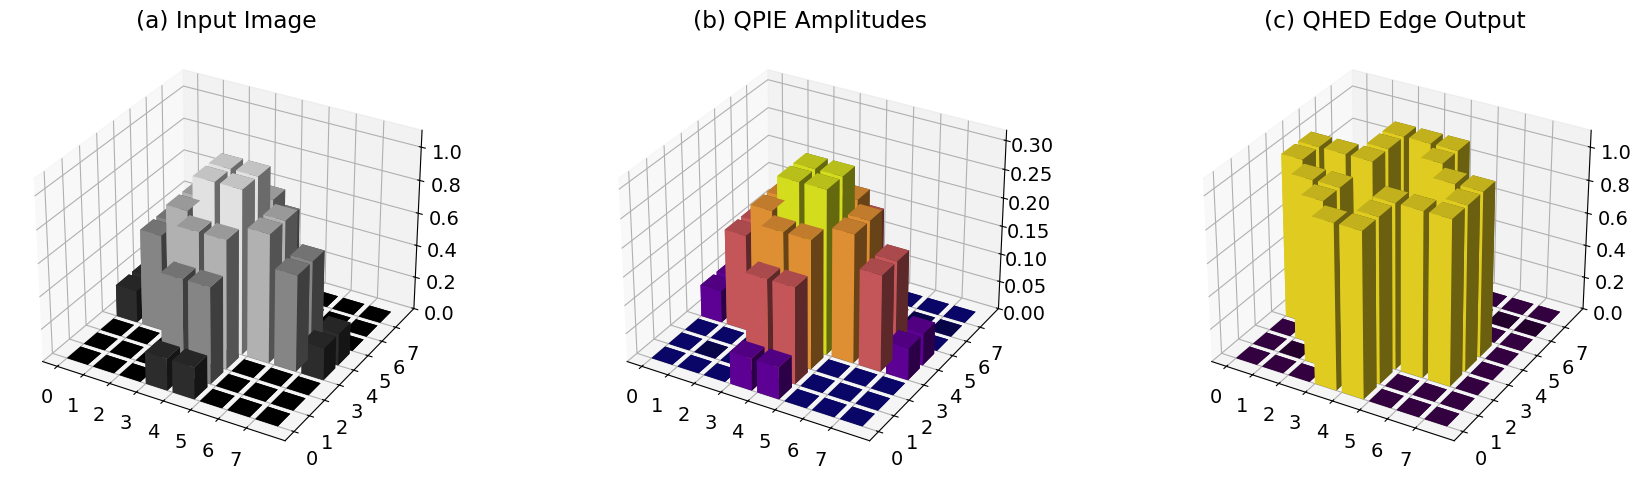

In [ ]:
#3D Bar Plotting
plt.rcParams.update({'font.size': 14})
def plot_3d(ax, grid, title, cmap='viridis'):
    X, Y = np.meshgrid(range(grid.shape[0]), range(grid.shape[1]), indexing='ij')
    X = X.flatten(); Y = Y.flatten(); Z = grid.flatten()
    dx = dy = 0.8
    norm = Z.max() if Z.max() != 0 else 1
    colors = plt.cm.get_cmap(cmap)(Z / norm)
    ax.bar3d(X, Y, np.zeros_like(Z), dx, dy, Z, color=colors, shade=True)
    ax.set_title(title)
    ax.set_xticks(range(grid.shape[0]))
    ax.set_yticks(range(grid.shape[1]))
    ax.set_zlim(0, Z.max() * 1.1 if Z.max() > 0 else 1)

# Plot the 3 panels
fig = plt.figure(figsize=(18, 5))
titles = ['(a) Input Image', '(b) QPIE Amplitudes', '(c) QHED Edge Output']
grids = [image_norm, amps_grid, edges]
cmaps = ['gray', 'plasma', 'viridis']

for i, (t, g, c) in enumerate(zip(titles, grids, cmaps), start=1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    plot_3d(ax, g, t, cmap=c)

plt.tight_layout()
plt.savefig("qhed_3d_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# 256 x 256 Image and Comparison with Classical Algorithms


Processing: mountain.jpg


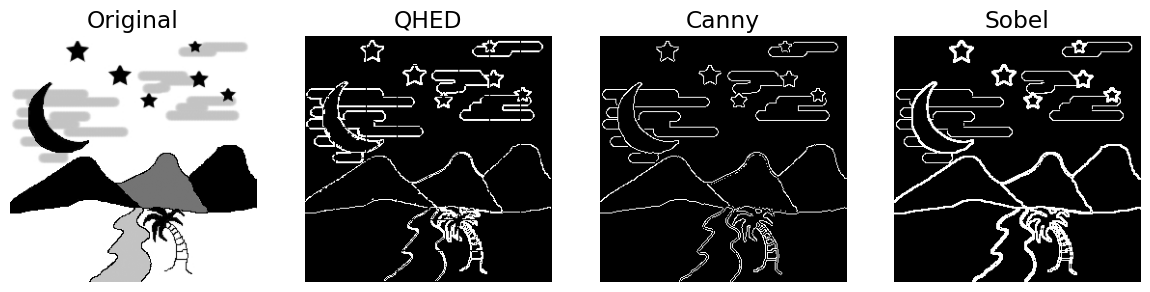


Processing: lena.jpg


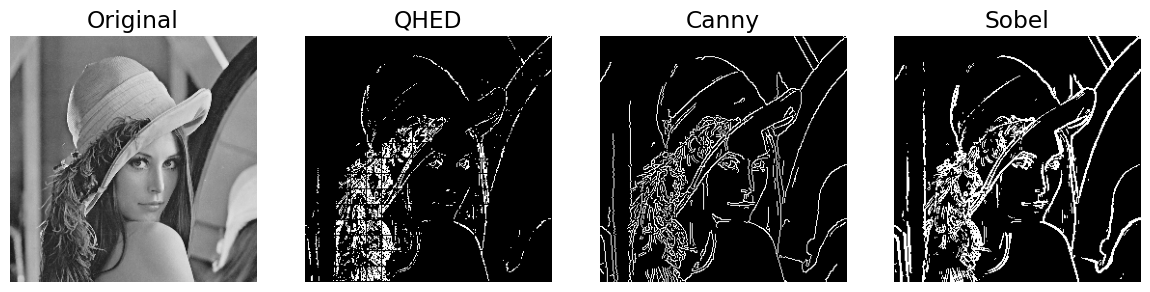


Processing: camera.jpg


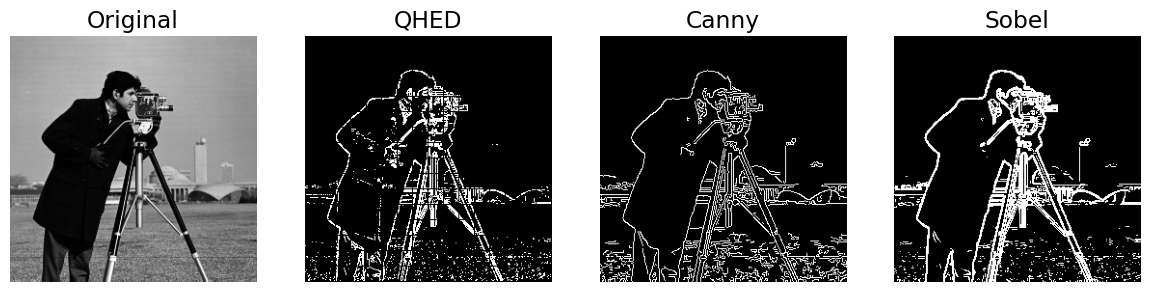

In [ ]:
def plot_comparison(images, titles, figsize=(12, 3)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

image_filenames = ["mountain.jpg", "lena.jpg", "camera.jpg"]
image_size = 256
image_crop_size = 32

for filename in image_filenames:
    print(f"\nProcessing: {filename}")

    # Load and normalize image
    image_pil = Image.open(filename).convert('L').resize((image_size, image_size))
    image_raw = np.array(image_pil)
    image = image_raw.astype(np.float32) / 255.0

    # Determine the threshold based on the filename
    if filename == "mountain.jpg":
        current_threshold = lambda amp: abs(amp) > 1e-3
    else:
        current_threshold = lambda amp: abs(amp) > 1e-2
        image_crop_size = 16


    # Apply Quantum Edge Detection with the specific threshold
    qhed = quantum_edge_detect(image, image_crop_size, threshold = current_threshold)

    # Convert image to uint8 for OpenCV
    image_uint8 = (image * 255).astype(np.uint8)

    # Apply Canny and Sobel
    edges_canny = cv.Canny(image_uint8, 100, 200)
    edges_sobel = sobel(image)
    edges_sobel_display = (edges_sobel > 0.1).astype(np.uint8) * 255 # Keeping Sobel threshold consistent


    # Display side-by-side
    plot_comparison(
        [image, qhed, edges_canny, edges_sobel_display],
        ["Original", "QHED", "Canny", "Sobel"]
    )

# Circuit Depth and Gate Count

In [ ]:
def analyze_qhed_complexity(w):
    print(f"\nAnalyzing QHED circuit for patch size {w}x{w}")

    # Determine qubits
    data_qb = int(np.log2(w * w))
    anc_qb = 1
    total_qb = data_qb + anc_qb

    # Generate random grayscale patch in [0, 1]
    patch = np.random.rand(w, w).astype(np.float32)

    # Amplitude encode
    img_norm = amplitude_encode(patch)

    # Define the decrement unitary
    D2n_1 = np.roll(np.eye(2**total_qb), 1, axis=1)

    # Build QHED circuit
    qc = QuantumCircuit(total_qb)
    qc.initialize(img_norm, range(1, total_qb))  # Data qubits only
    qc.h(0)  # Ancilla
    qc.unitary(D2n_1, range(total_qb))  # Decrement
    qc.h(0)  # Ancilla

    # Transpile for gate analysis
    tqc = transpile(qc, basis_gates=['u3', 'cx'], optimization_level=0)

    depth = tqc.depth()
    ops = tqc.count_ops()

    print(f"Circuit Depth: {depth}, Gate Counts: {ops}")

    return {
        'patch_size': w,
        'qubits': total_qb,
        'depth': depth,
        'u3': ops.get('u3', 0),
        'cx': ops.get('cx', 0)
    }

In [ ]:
patch_sizes = [2, 4, 8, 16]
results = [analyze_qhed_complexity(w) for w in patch_sizes]
df = pd.DataFrame(results)


Analyzing QHED circuit for patch size 2x2
Circuit Depth: 49, Gate Counts: OrderedDict([('u3', 47), ('cx', 21), ('reset', 2)])

Analyzing QHED circuit for patch size 4x4
Circuit Depth: 1034, Gate Counts: OrderedDict([('u3', 920), ('cx', 455), ('reset', 4)])

Analyzing QHED circuit for patch size 8x8
Circuit Depth: 17702, Gate Counts: OrderedDict([('u3', 15448), ('cx', 7717), ('reset', 6)])

Analyzing QHED circuit for patch size 16x16
Circuit Depth: 287905, Gate Counts: OrderedDict([('u3', 250199), ('cx', 125091), ('reset', 8)])


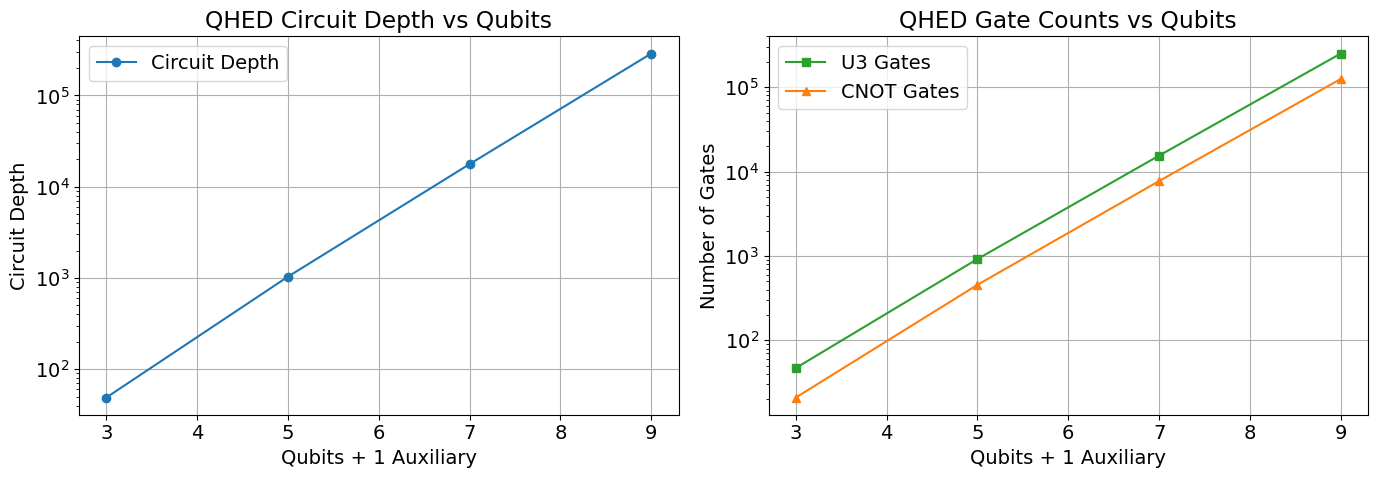

In [ ]:
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Circuit Depth ---
axes[0].plot(df['qubits'], df['depth'], marker='o', color='tab:blue', label='Circuit Depth')
axes[0].set_title('QHED Circuit Depth vs Qubits')
axes[0].set_xlabel('Qubits + 1 Auxiliary')
axes[0].set_ylabel('Circuit Depth')
axes[0].set_yscale('log')
axes[0].grid(True)
axes[0].legend()

# --- Plot 2: Gate Counts ---
axes[1].plot(df['qubits'], df['u3'], marker='s', linestyle='-', color='tab:green', label='U3 Gates')
axes[1].plot(df['qubits'], df['cx'], marker='^', linestyle='-', color='tab:orange', label='CNOT Gates')
axes[1].set_title('QHED Gate Counts vs Qubits')
axes[1].set_xlabel('Qubits + 1 Auxiliary')
axes[1].set_ylabel('Number of Gates')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend()

# --- Layout and Save ---
plt.tight_layout()
plt.savefig("qhed_circuit_scaling.png", dpi=300, bbox_inches='tight')
plt.show()

# Edge Detection Quality

In [ ]:
images_info = [
    ('lena.jpg',     1e-2),
    ('camera.jpg',   1e-2),
    ('mountain.jpg', 1e-3),
]
image_size = 256

patch_sizes = [2, 4, 8, 16, 32]

# Storage for PSNR values
psnr_sobel = {name: [] for name, _ in images_info}
psnr_canny = {name: [] for name, _ in images_info}

for filename, thresh in images_info:
    print(f"\nProcessing: {filename}")

    # Load & normalize
    image_pil = Image.open(filename).convert('L').resize((image_size, image_size))
    image_raw = np.array(image_pil)
    image = image_raw.astype(np.float32) / 255.0

    # Sobel
    sobel = filters.sobel(image)
    sobel_binary = (sobel > 0.1).astype(int)

    # Canny
    img_u8 = (image * 255).astype(np.uint8)
    canny = cv.Canny(img_u8, 100, 200)
    canny_binary = (canny > 0).astype(int)


    for w in patch_sizes:
        # Quantum edge map, threshold per-image
        q_edge = quantum_edge_detect(image, w, threshold=lambda amp: abs(amp) > thresh).astype(int)

        # PSNR vs Sobel
        psnr_s = peak_signal_noise_ratio(sobel_binary, q_edge, data_range=1)
        psnr_sobel[filename].append(psnr_s)

        # PSNR vs Canny
        psnr_c = peak_signal_noise_ratio(canny_binary, q_edge, data_range=1)
        psnr_canny[filename].append(psnr_c)


Processing: lena.jpg

Processing: camera.jpg

Processing: mountain.jpg


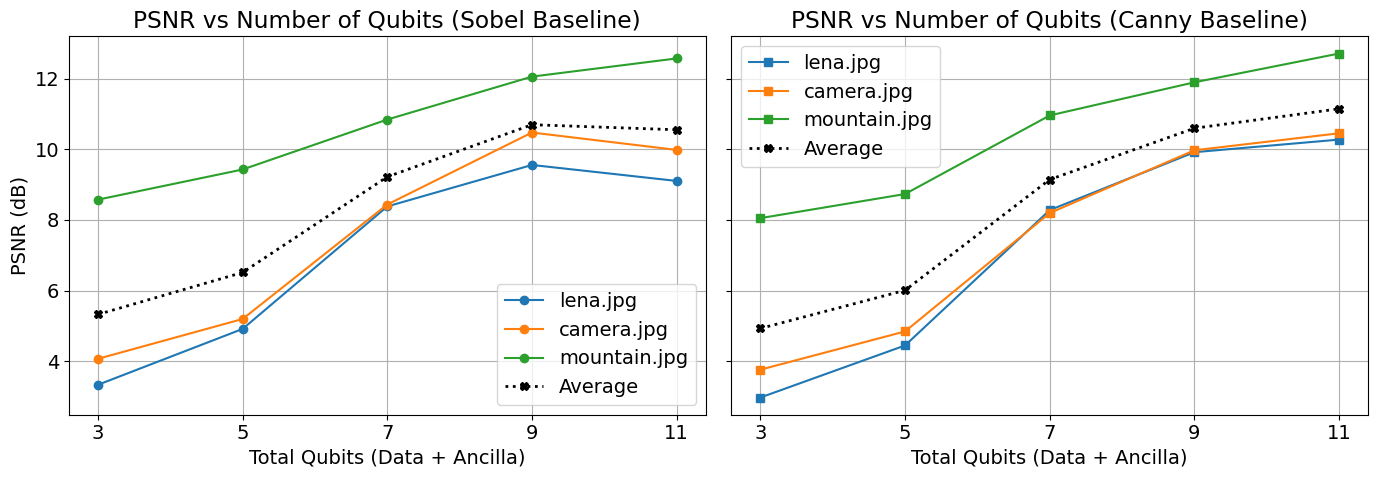

In [ ]:
avg_sobel = np.mean([psnr_sobel[name] for name, _ in images_info], axis=0)
avg_canny = np.mean([psnr_canny[name] for name, _ in images_info], axis=0)

qubit_counts = [int(np.log2(w*w)) + 1 for w in patch_sizes]
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Sobel
for filename, _ in images_info:
    axes[0].plot(qubit_counts, psnr_sobel[filename], marker='o', label=filename)
axes[0].plot(qubit_counts, avg_sobel, marker='X', linestyle=':', linewidth=2, color='k', label='Average')
axes[0].set_title('PSNR vs Number of Qubits (Sobel Baseline)')
axes[0].set_xlabel('Total Qubits (Data + Ancilla)')
axes[0].set_ylabel('PSNR (dB)')
axes[0].set_xticks(qubit_counts)
axes[0].grid(True)
axes[0].legend(loc='best')

# Canny
for filename, _ in images_info:
    axes[1].plot(qubit_counts, psnr_canny[filename], marker='s', label=filename)
axes[1].plot(qubit_counts, avg_canny, marker='X', linestyle=':', linewidth=2, color='k', label='Average')
axes[1].set_title('PSNR vs Number of Qubits (Canny Baseline)')
axes[1].set_xlabel('Total Qubits (Data + Ancilla)')
axes[1].set_xticks(qubit_counts)
axes[1].grid(True)
axes[1].legend(loc='best')

plt.tight_layout()
plt.savefig("psnr_qubits.png", dpi=300, bbox_inches='tight',transparent=True)
plt.show()